In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

In [2]:
pd.set_option("display.max_columns", None)



In [3]:
data_path = '../data/uci_data.xls'

df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)
df = df.rename(columns={'PAY_0': 'PAY_1'})

# I set all invalid values to 'other'
df.loc[~(df['EDUCATION'].isin([1, 2, 3, 4])), 'EDUCATION'] = 4
df.loc[~(df['MARRIAGE'].isin([1, 2, 3])), 'MARRIAGE'] = 3

# PAY_* fuera de rango
paux = ~(df['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))
for i in range(2, 7):
    paux = paux | ~(df['PAY_' + str(i)].isin([-1,0,1,2,3,4,5,6,7,8,9]))
    
df = df[~paux]

categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

df[categorical_cols] = df[categorical_cols].astype('category')

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop(columns=("default payment next month"))
y_train = train[["default payment next month"]]
X_test = test.drop(columns=("default payment next month"))
y_test = test[["default payment next month"]]

In [5]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

categorical_features = X_train.select_dtypes(include='category').columns.tolist()

In [6]:
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Apply one-hot encoder to each column with categorical data
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_train = pd.DataFrame(ohe.fit_transform(X_train[categorical_features]))
ohe_test = pd.DataFrame(ohe.transform(X_test[categorical_features]))

# One-hot encoding removed index; put it back
ohe_train.index = X_train.index
ohe_test.index = X_test.index
ohe_train.columns = ohe.get_feature_names(categorical_features)
ohe_test.columns = ohe.get_feature_names(categorical_features)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_features, axis=1)
num_X_test = X_test.drop(categorical_features, axis=1)

# Add one-hot encoded columns to numerical features
ohe_X_train = pd.concat([num_X_train, ohe_train], axis=1)
ohe_X_test = pd.concat([num_X_test, ohe_test], axis=1)
ohe_X_train

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29366,-0.831928,-1.210027,-0.650467,-0.657047,-0.504071,-0.479666,-0.628858,-0.629335,-0.239417,-0.255924,-0.254647,-0.300406,-0.301686,-0.285243,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29255,-0.831928,-1.102875,-0.157251,-0.142776,-0.137837,-0.079685,-0.040434,-0.000228,-0.253209,-0.203610,-0.202398,-0.237792,-0.200430,-0.177269,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21187,1.905457,-0.352811,-0.069652,-0.048205,-0.080130,-0.070968,0.000988,0.059047,-0.186883,-0.160163,-0.145605,-0.133652,-0.135772,1.912824,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15756,-0.753717,-1.317179,-0.008904,0.007749,0.022902,-0.077687,-0.331155,-0.291855,-0.188563,-0.206355,-0.142823,-0.133652,-0.135642,-0.249003,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7506,-0.597295,0.182949,0.242721,0.070819,-0.060417,0.058625,0.157899,0.129138,-0.367211,-0.223722,-0.032021,-0.068565,-0.071113,-0.198864,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15245,-0.597295,0.182949,-0.420787,-0.396635,-0.334970,-0.289140,-0.239521,-0.224756,-0.248532,-0.108588,-0.242152,-0.231283,-0.329748,-0.232979,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27563,-1.066561,1.897381,-0.544664,-0.539027,-0.537056,-0.498211,-0.472670,-0.450180,-0.290510,-0.245842,-0.242152,-0.283353,-0.284487,-0.270540,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6915,-0.44087

### Logistic Regression

In [7]:
lg_clf = LogisticRegression(solver='liblinear',
                         class_weight='balanced', 
                         max_iter=5000)

In [8]:
%%time
lg_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 310 ms, sys: 4.2 ms, total: 315 ms
Wall time: 314 ms


LogisticRegression(class_weight='balanced', max_iter=5000, solver='liblinear')

In [9]:
from joblib import dump, load
dump(lg_clf, 'lr.joblib')

['lr.joblib']

In [10]:
print(metrics.classification_report(y_train, lg_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.88      0.85      0.86     14480
     default       0.54      0.60      0.57      4271

    accuracy                           0.79     18751
   macro avg       0.71      0.73      0.72     18751
weighted avg       0.80      0.79      0.80     18751



In [11]:
print(metrics.classification_report(y_test, lg_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.87      0.86      0.86      3574
     default       0.56      0.59      0.58      1114

    accuracy                           0.79      4688
   macro avg       0.72      0.72      0.72      4688
weighted avg       0.80      0.79      0.80      4688



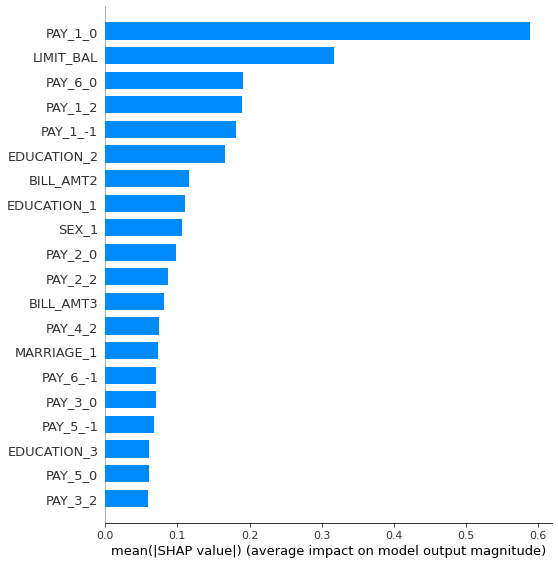

In [12]:
explainer = shap.LinearExplainer(lg_clf, ohe_X_train)
shap_values = explainer.shap_values(ohe_X_train)
dump(shap_values, 'lr_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_test, plot_type='bar')

In [13]:
lr_shap = list(ohe_X_test.columns[np.argsort(-np.abs(shap_values).mean(0))])

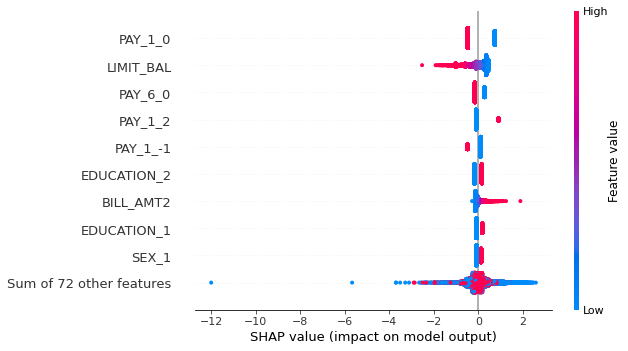

In [14]:
explainer = shap.Explainer(lg_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'lr_shapbee.joblib')
shap.plots.beeswarm(shap_values)

In [15]:
choosen_instance = ohe_X_train.loc[[31]]
explainer = shap.Explainer(lg_clf, ohe_X_train)
choosen_shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, choosen_shap_values, choosen_instance)

In [16]:
selector = RFE(lg_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())
lg_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

w = [(n, selector.ranking_[i]) for i, n in lg_rfe]
lr_rfe = w.sort(key=lambda x: x[1])

### Ridge Classifier

In [17]:
rg_clf = RidgeClassifier(alpha=0.5)

In [18]:
%%time
rg_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 44.7 ms, sys: 16.8 ms, total: 61.4 ms
Wall time: 30.7 ms


RidgeClassifier(alpha=0.5)

In [19]:
dump(rg_clf, 'rc.joblib')

['rc.joblib']

In [20]:
print(metrics.classification_report(y_train, rg_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.68      0.42      0.52      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.71     18751
weighted avg       0.81      0.82      0.81     18751



In [21]:
print(metrics.classification_report(y_test, rg_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.41      0.52      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.71      4688
weighted avg       0.81      0.82      0.80      4688



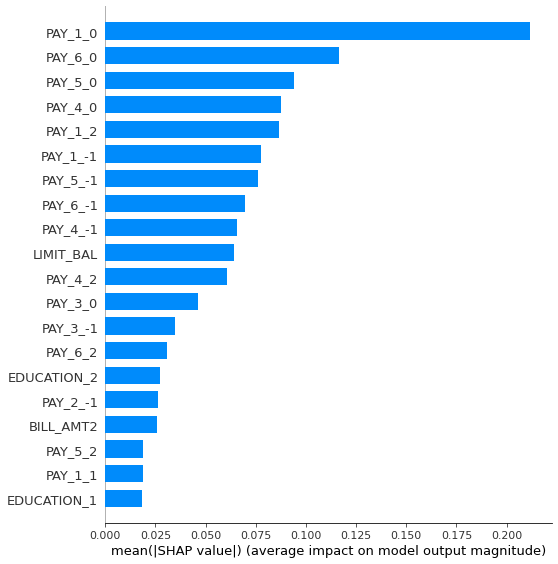

In [22]:
explainer = shap.Explainer(rg_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'rc_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_test, plot_type='bar')

In [23]:
rg_shap = list(ohe_X_test.columns[np.argsort(-np.abs(shap_values.values).mean(0))])

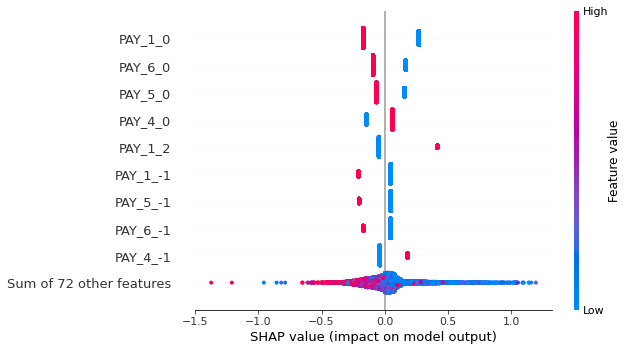

In [24]:
explainer = shap.Explainer(rg_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'rc_shapbee.joblib')
shap.plots.beeswarm(shap_values)

In [25]:
selector = RFE(rg_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())
rg_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

w = [(n, selector.ranking_[i]) for i, n in rg_rfe]
rg_rfe = w.sort(key=lambda x: x[1])

### Random Forest

In [26]:
rf_clf = RandomForestClassifier(criterion='entropy', min_samples_leaf=4, n_estimators=60)

In [27]:
%%time
rf_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 2.73 s, sys: 81.6 ms, total: 2.82 s
Wall time: 2.62 s


RandomForestClassifier(criterion='entropy', min_samples_leaf=4, n_estimators=60)

In [28]:
dump(rf_clf, 'rf.joblib')

['rf.joblib']

In [29]:
print(metrics.classification_report(y_train, rf_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.89      0.98      0.93     14480
     default       0.90      0.57      0.70      4271

    accuracy                           0.89     18751
   macro avg       0.89      0.78      0.82     18751
weighted avg       0.89      0.89      0.88     18751



In [30]:
print(metrics.classification_report(y_test, rf_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.70      4688
weighted avg       0.81      0.82      0.80      4688



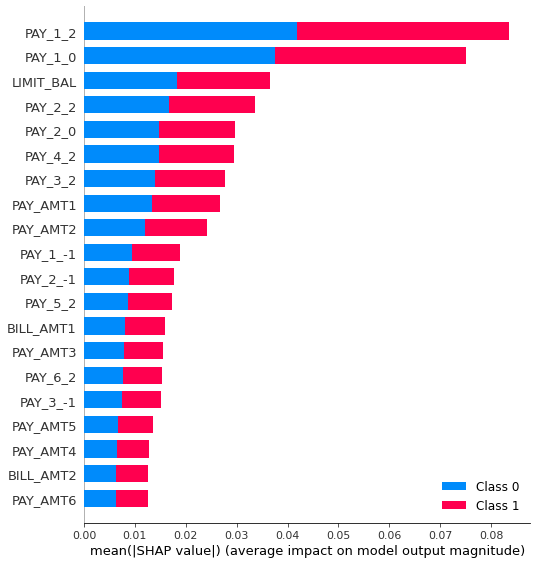

CPU times: user 25min 12s, sys: 1.68 s, total: 25min 14s
Wall time: 25min 9s


In [31]:
%%time
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(ohe_X_train)
dump(shap_values, 'rf_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_train, plot_type='bar')

In [32]:
rf_shap = list(ohe_X_test.columns[np.argsort(-np.abs(shap_values).mean(0).mean(0))])

In [45]:
%%time
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(ohe_X_train)
shap_obj = explainer(ohe_X_train)
dump(shap_obj, 'rf_shapbee.joblib')

CPU times: user 50min 11s, sys: 3.46 s, total: 50min 15s
Wall time: 50min 6s


['rf_shapbee.joblib']

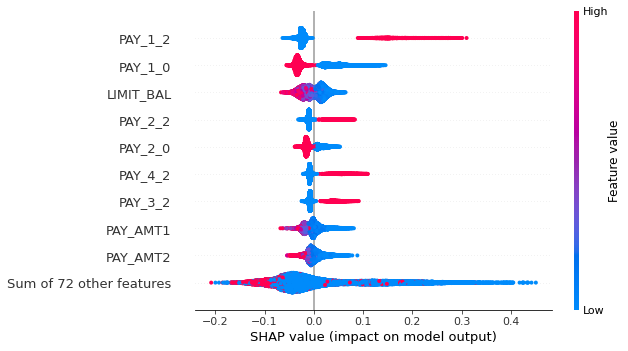

In [46]:
shap.plots.beeswarm(shap_obj[:,:,1])

### Adaboost

In [35]:
ab_clf = AdaBoostClassifier(learning_rate=1.3, n_estimators=60)

In [36]:
%%time
ab_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 1.9 s, sys: 4.01 ms, total: 1.91 s
Wall time: 1.91 s


AdaBoostClassifier(learning_rate=1.3, n_estimators=60)

In [37]:
dump(ab_clf, 'ab.joblib')

['ab.joblib']

In [38]:
print(metrics.classification_report(y_train, ab_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.67      0.42      0.51      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.70     18751
weighted avg       0.81      0.82      0.80     18751



In [39]:
print(metrics.classification_report(y_test, ab_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.70      4688
weighted avg       0.81      0.82      0.80      4688



In [40]:
explainer = shap.Explainer(ab_clf.predict, ohe_X_test)

In [41]:
%%time
shap_values = explainer(ohe_X_train)
dump(shap_values, 'ab_shapbars.joblib')
dump(shap_values, 'ab_shapbee.joblib')

Permutation explainer: 18752it [1:52:26,  2.78it/s]                           


CPU times: user 1h 52min 27s, sys: 4.37 s, total: 1h 52min 32s
Wall time: 1h 52min 26s


['ab_shapbee.joblib']

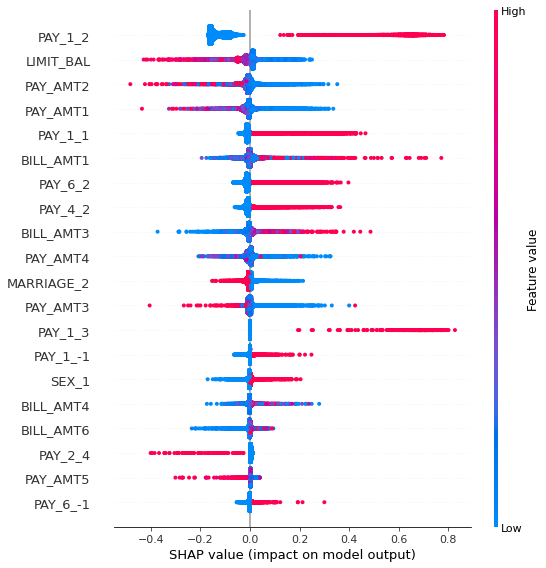

In [42]:
shap.summary_plot(shap_values, ohe_X_train)

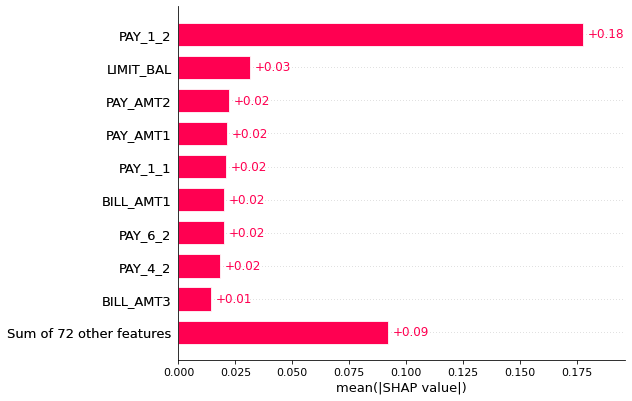

In [43]:
shap.plots.bar(shap_values)

In [44]:
shap.force_plot(explainer.expected_value, shap_values, ohe_X_test)

AttributeError: 'Permutation' object has no attribute 'expected_value'

In [ ]:
type(explainer)